In [1]:
import numpy as np
import pandas as pd
import torch 
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

In [2]:
with open('/content/drive/MyDrive/projects/AutoEncoder/data/mitdbx_mitdbx_108.txt') as f:
  data = f.readlines()
  data = [d[:-1].split() for d in data]

In [3]:
df = pd.DataFrame(data, columns=['data0', 'data1', 'data2'])
df = df.astype(float)
df.head()

,data0,data1,data2
0,0.000,4.995,4.34
1,0.003,4.995,4.34
2,0.006,4.995,4.34
3,0.008,4.995,4.34
4,0.011,4.995,4.34


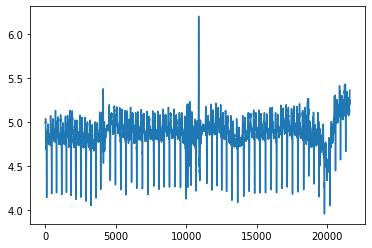

In [4]:
df['data1'].plot()

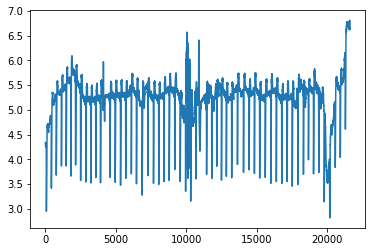

In [5]:
df['data2'].plot()

In [6]:
df.to_csv('/content/drive/MyDrive/projects/AutoEncoder/data/mitdbx_mitdbx_108.csv')

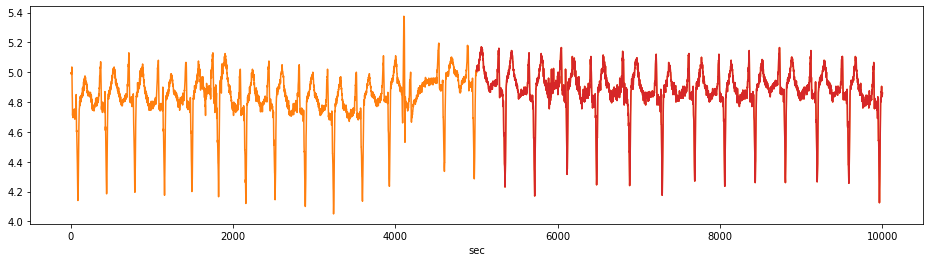

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))
plt.plot(df.iloc[0 : 10000].index, df.iloc[0 : 10000]['data1'], color='tab:orange', label='Test')

plt.plot(df.iloc[5000 : 10000].index, df.iloc[5000 : 10000]['data1'], color='tab:red', label='Test')
plt.xlabel('sec')

plt.show()

In [8]:
df.loc[(df.index>=4000)&(df.index<5000), 'label'] = 1
df['label'] = df['label'].fillna(0)
df.head()

,data0,data1,data2,label
0,0.000,4.995,4.34,0.0
1,0.003,4.995,4.34,0.0
2,0.006,4.995,4.34,0.0
3,0.008,4.995,4.34,0.0
4,0.011,4.995,4.34,0.0


In [9]:
np.bincount(df['label'])

array([20600,  1000])

In [15]:
Xtr = df['data1'].iloc[5000:10000].to_numpy() # 正常
Ytr = df['label'].iloc[5000:10000].to_numpy()
Xts = df['data1'].loc[:4999].to_numpy() # 異常込み
Yts = df['label'].iloc[:4999].to_numpy()
Xtr = Xtr.reshape(-1, 1)
Xts = Xts.reshape(-1, 1)

print(Xtr.shape, Xts.shape)

(5000, 1) (5000, 1)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtr_norm = scaler.fit_transform(Xtr).reshape(-1, )
Xts_norm = scaler.transform(Xts).reshape(-1, )

print(Xtr_norm.shape, Xts_norm.shape)

(5000,) (5000,)


In [17]:
class AEDataset(Dataset):
  def __init__(self, data, window_size):
    self.data = torch.Tensor(data)
    self.window_size = window_size

  def __len__(self):
    return len(self.data) - self.window_size # data - M
  
  def __getitem__(self, index):
    return self.data[index : index+self.window_size]

window_size = 250
BATCH_SIZE = 32
train_dataloader = DataLoader(AEDataset(Xtr_norm, window_size), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(AEDataset(Xts_norm, window_size), batch_size=1)
dataloaders_dict = {'train': train_dataloader}

In [19]:
model = nn.Sequential(
    nn.Linear(window_size, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, window_size)
)

opt = optim.Adam(model.parameters())
n_epoch = 30
criterion = nn.MSELoss()

In [20]:
def train_model(model, criterion, optimizer, num_epochs=10):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    for epoch in range(num_epochs):
        print('-' * 20)
        print('Epoch {}'.format(epoch+1))

        for phase in ['train']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

    return model

model = train_model(model, criterion, opt, n_epoch)

cpu
--------------------
Epoch 1
train Loss: 0.6933
--------------------
Epoch 2
train Loss: 0.4614
--------------------
Epoch 3
train Loss: 0.2952
--------------------
Epoch 4
train Loss: 0.2261
--------------------
Epoch 5
train Loss: 0.1697
--------------------
Epoch 6
train Loss: 0.1407
--------------------
Epoch 7
train Loss: 0.1301
--------------------
Epoch 8
train Loss: 0.1265
--------------------
Epoch 9
train Loss: 0.1086
--------------------
Epoch 10
train Loss: 0.1056
--------------------
Epoch 11
train Loss: 0.1178
--------------------
Epoch 12
train Loss: 0.0948
--------------------
Epoch 13
train Loss: 0.0898
--------------------
Epoch 14
train Loss: 0.0941
--------------------
Epoch 15
train Loss: 0.0978
--------------------
Epoch 16
train Loss: 0.0925
--------------------
Epoch 17
train Loss: 0.0802
--------------------
Epoch 18
train Loss: 0.0839
--------------------
Epoch 19
train Loss: 0.0711
--------------------
Epoch 20
train Loss: 0.0721
--------------------
Epoc

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
test_dataloader = DataLoader(AEDataset(Xts_norm, window_size), batch_size=1)
recon = []  
for i, inputs in enumerate(test_dataloader):
  inputs = inputs.to(device)
  
  with torch.set_grad_enabled(False):
     outputs = model(inputs)
     if i == 0:
       recon.extend(outputs[0].to('cpu').detach().tolist())
     else:
       recon.extend(outputs[:, -1].to('cpu').detach())

recon = np.array(recon)

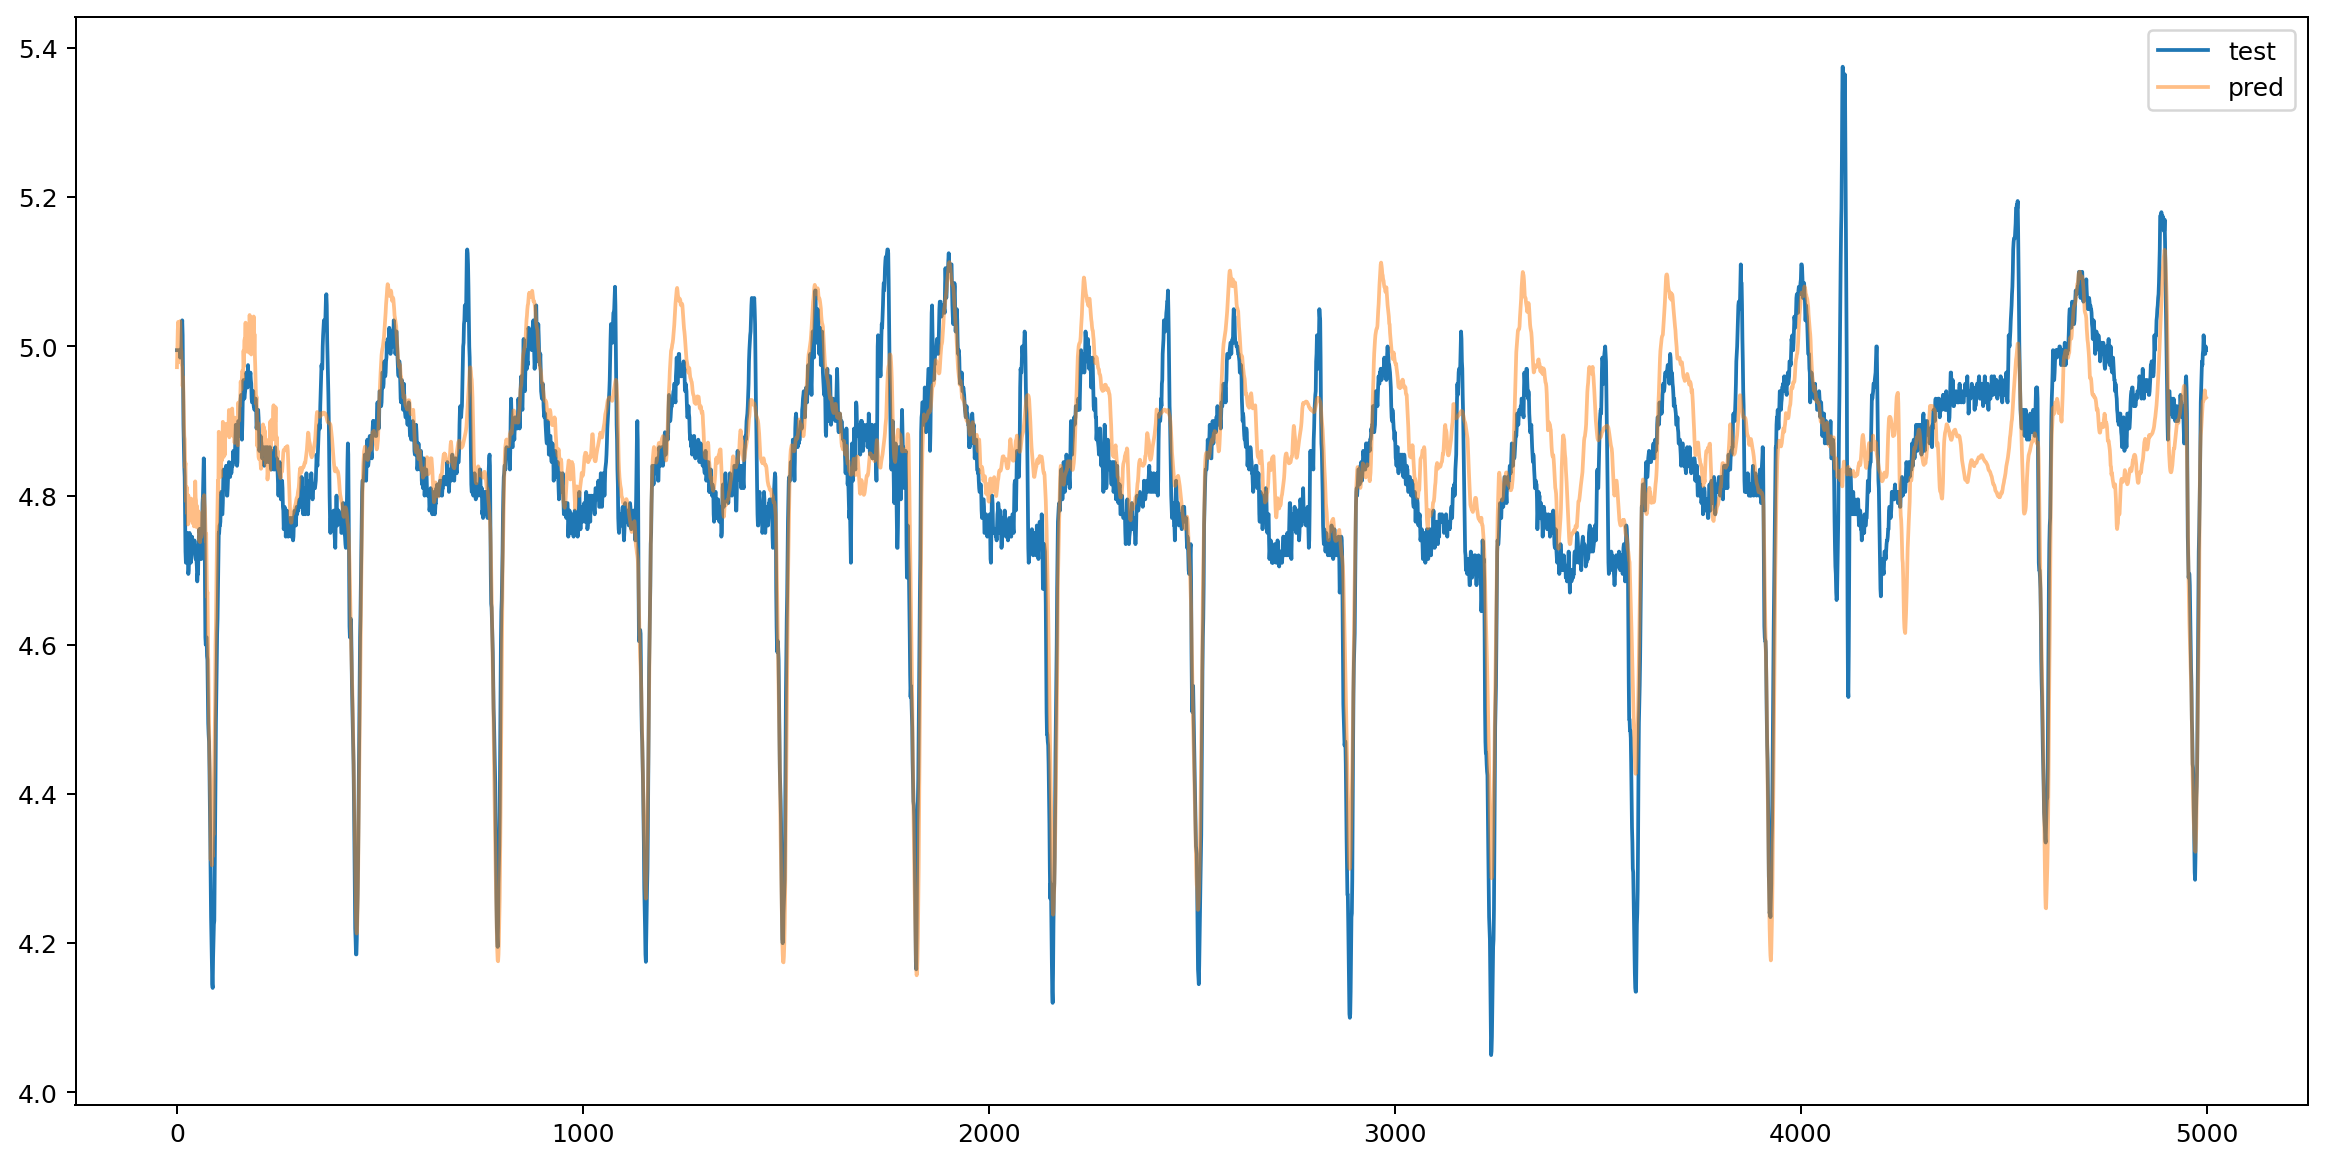

In [25]:
# テストデータと出力データの可視化

y = scaler.inverse_transform(Xts_norm[:-1].reshape(-1, 1)).reshape(-1, )
y_pred = scaler.inverse_transform(recon.reshape(-1, 1)).reshape(-1, )

fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.add_subplot(111)
ax.plot(y, label='test')
ax.plot(y_pred, alpha=0.5, label='pred')
plt.legend()
plt.show()

No handles with labels found to put in legend.


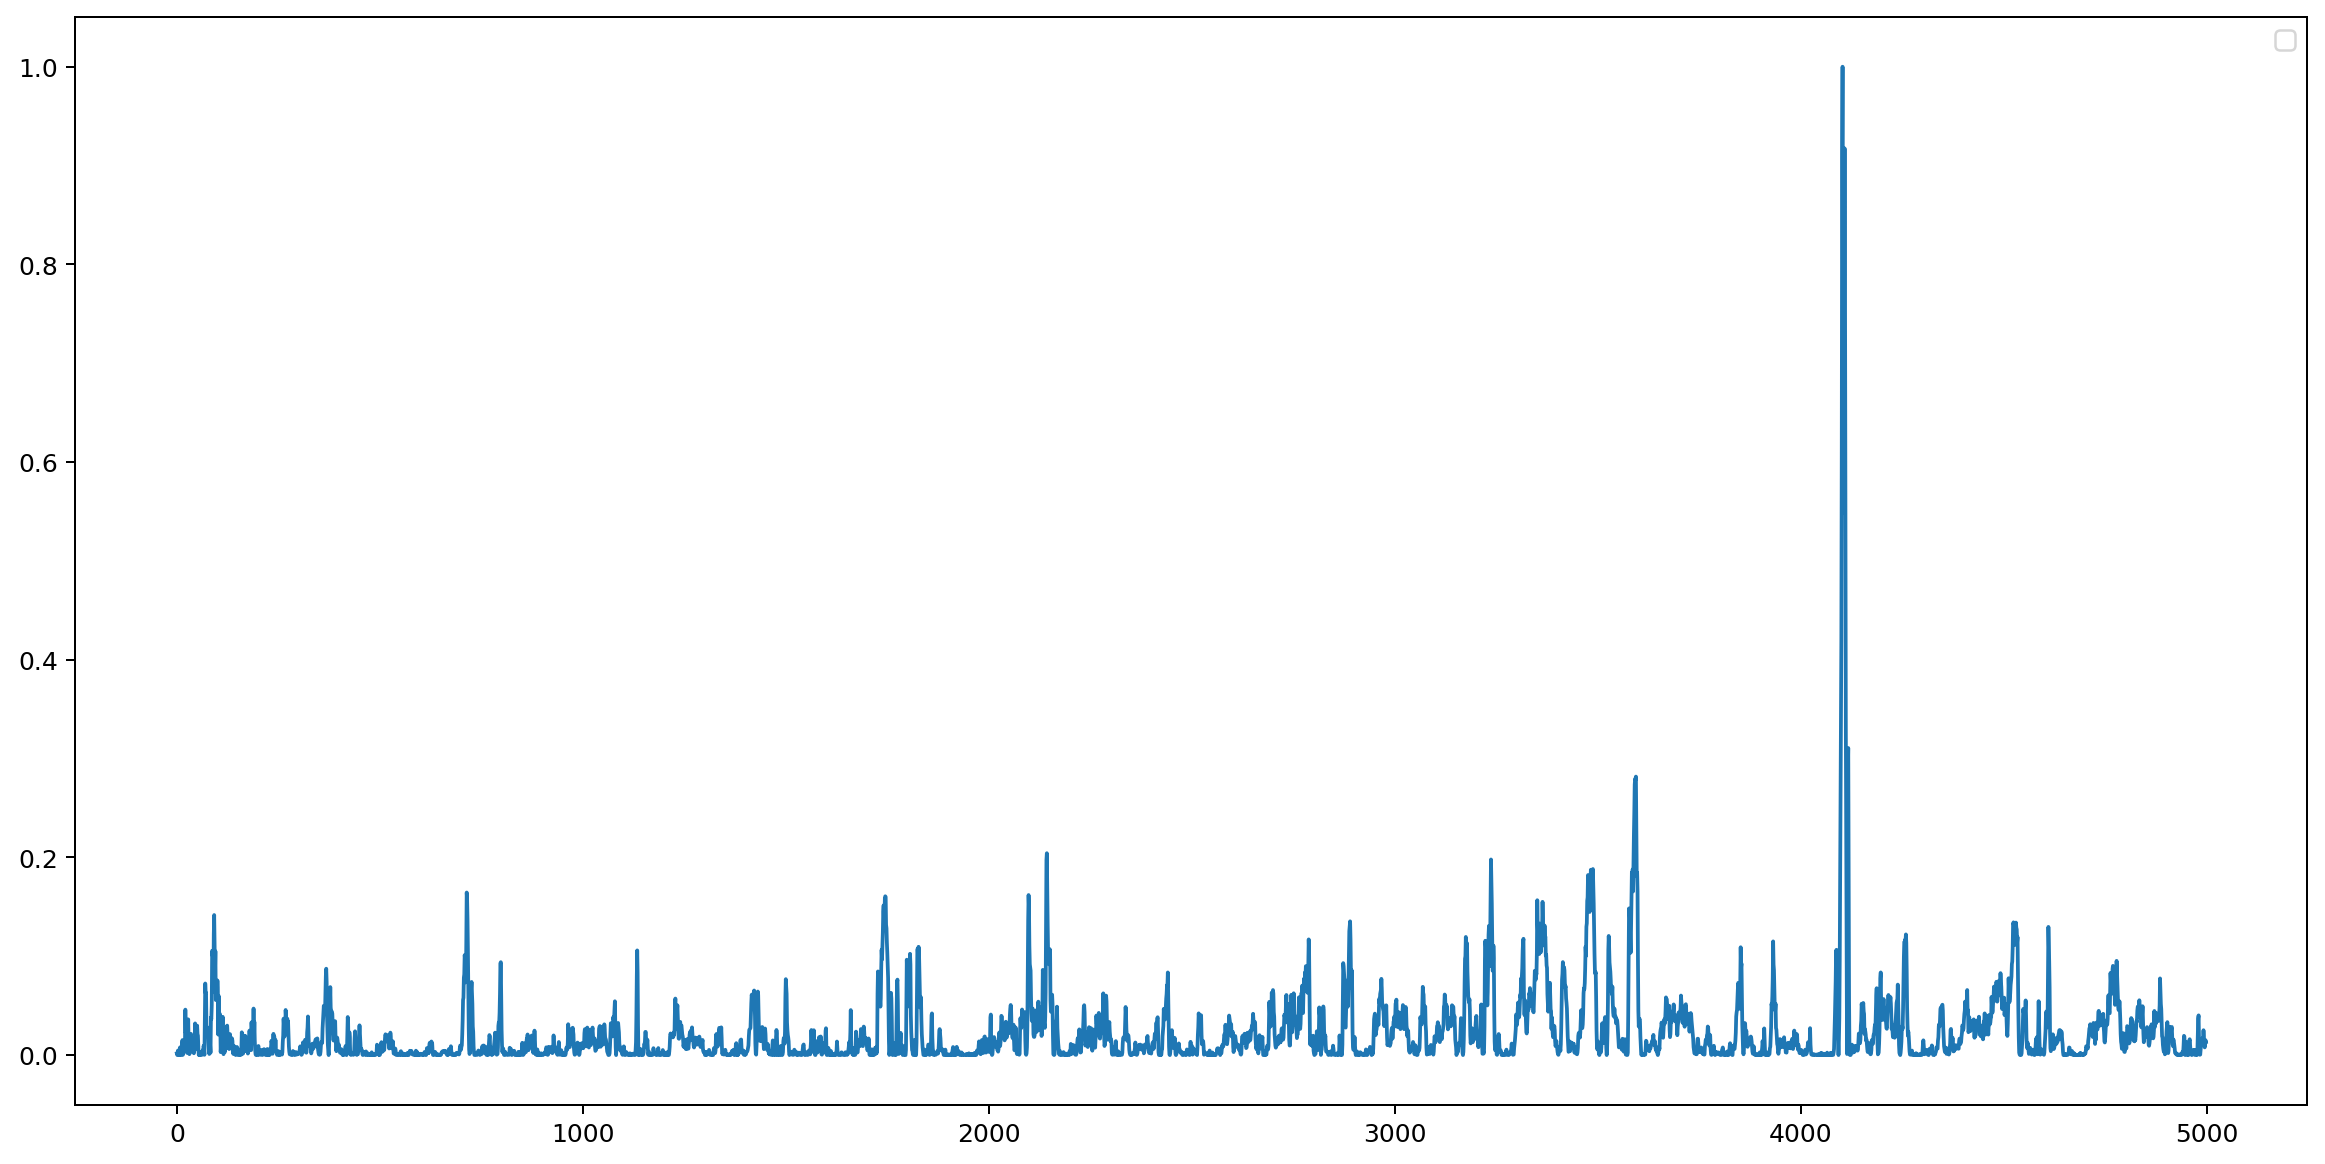

In [26]:
# 再構成誤差
dist = y - y_pred
dist = pow(dist, 2)
dist = dist / np.max(dist)


fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.add_subplot(111)
ax.plot(dist)
plt.legend()
plt.show()

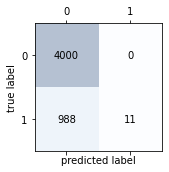

Precision：1.0.
Recall：0.011011011011011011.


In [27]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

pred_label = (dist > 0.4).astype(int)

targets = Yts
predictions = pred_label

confmat = confusion_matrix(y_true=targets, y_pred=predictions)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

precision = precision_score(targets, predictions)
recall = recall_score(targets, predictions)
print(f'Precision：{precision}.')
print(f'Recall：{recall}.')